In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import integrated_gradients
import seaborn as sns
import fiona
import geopandas as gpd

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [44]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
base = 'zeros' #zeros or mean
grad_steps = 50 #Number of steps to take in calculation of IG
year_index = -1 #Sequence to apply IG to
weights_file = f'../../river-dl/results/baseline/{mod}/rep_5/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/{mod}/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15
num_rand = 30 #number of random sequences to average some chunks


river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_tst'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]
segs = gpd.read_file('../../river-dl/data_DRB/DRB_spatial/segs/segs.shp')
seg_ids = river_dl['ids_tst'][-455:][:,0,:].flatten()
x_vars = river_dl['x_vars']
num_vars = len(x_vars)

if base == 'zeros':
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[455*year_index:]
    baseline = torch.zeros_like(x)

elif base == 'mean':
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()
    n_series = river_dl['x_tst'].shape[0]
    baseline = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)
    baseline = torch.mean(baseline,dim=0)
    x = x[455*year_index:]

dates_x = river_dl['times_tst'][455*year_index:][0].flatten()

x.shape,baseline.shape, adj_matrix.shape, device

(torch.Size([455, 60, 7]),
 torch.Size([455, 60, 7]),
 (455, 455),
 device(type='cuda', index=0))

In [45]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix,device=device)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)

model.eval()
model.to(device)

gwnet_wrapper(
  (model): gwnet(
    (start_conv): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
    (residual_convs): ModuleList(
      (0): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (5): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (6): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (7): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
      (8): Conv1d(32, 32, kernel_size=(1, 1), stride=(1,))
    )
    (skip_convs): ModuleList(
      (0): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (1): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (2): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (3): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))
      (4): Conv1d(32, 256, kernel_size=(1, 1), stride=(1,))

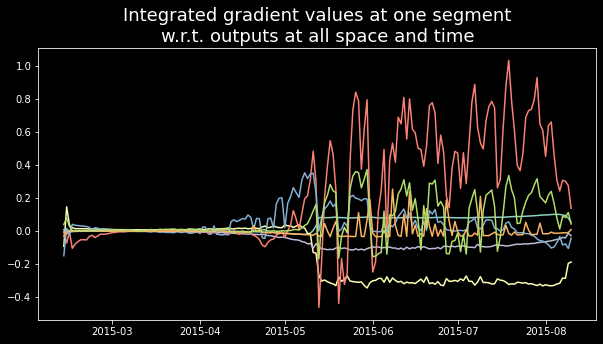

In [5]:
IG_vals = integrated_gradients(x, model, grad_steps, baseline, temporal_focus=range(pred_length,seq_len))
plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

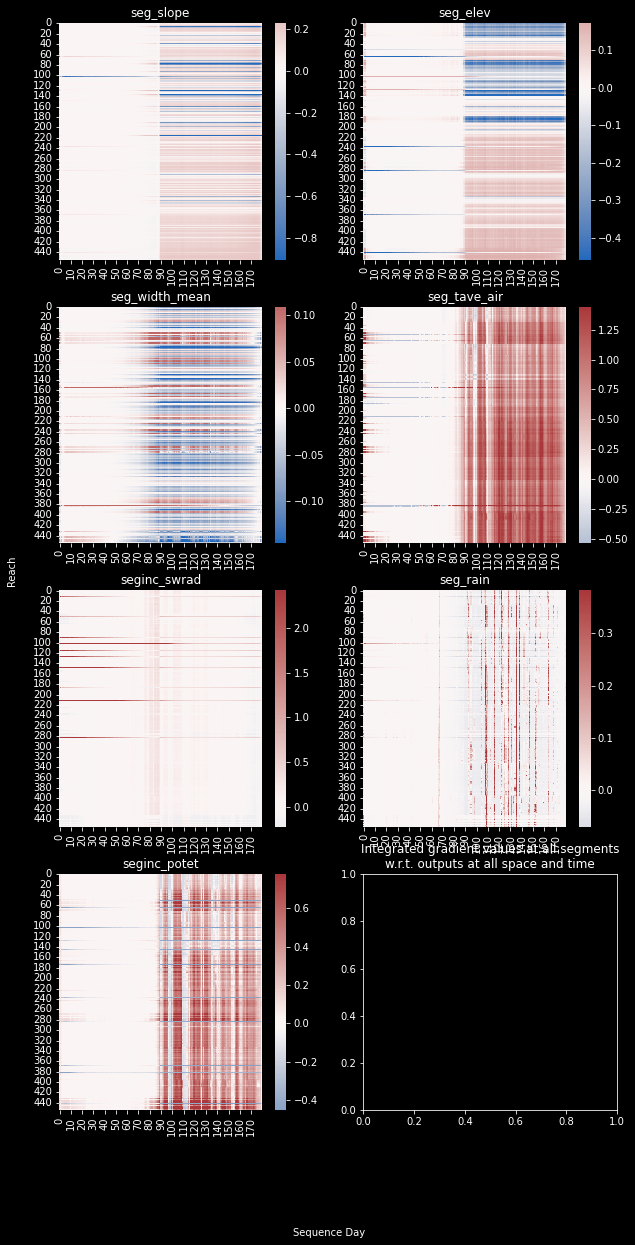

In [8]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(num_vars):
    IG = IG_vals[:,:,i]
    low_lim = np.quantile(IG,.01)
    high_lim = np.quantile(IG,.99)
    sns.heatmap(IG,vmin=low_lim,vmax=high_lim,center=0, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(x_vars[i])

fig.text(0.5, 0.04, 'Sequence Day', ha='center', va='center')
fig.text(0.06, 0.5, 'Reach', ha='center', va='center', rotation='vertical')
plt.tight_layout
plt.title('Integrated gradient values at all segments\nw.r.t. outputs at all space and time')
plt.show()

## lets try to make a seg to seg heatmap

In [9]:
seg2seg_influence = []
for i in range(455):
    IG_vals = integrated_gradients(x, model, grad_steps,baseline, spatial_focus=i, temporal_focus=range(pred_length,seq_len))
    reduced = np.mean(IG_vals,axis=1)
    seg2seg_influence.append(reduced)

seg2seg_influence=np.asarray(seg2seg_influence)

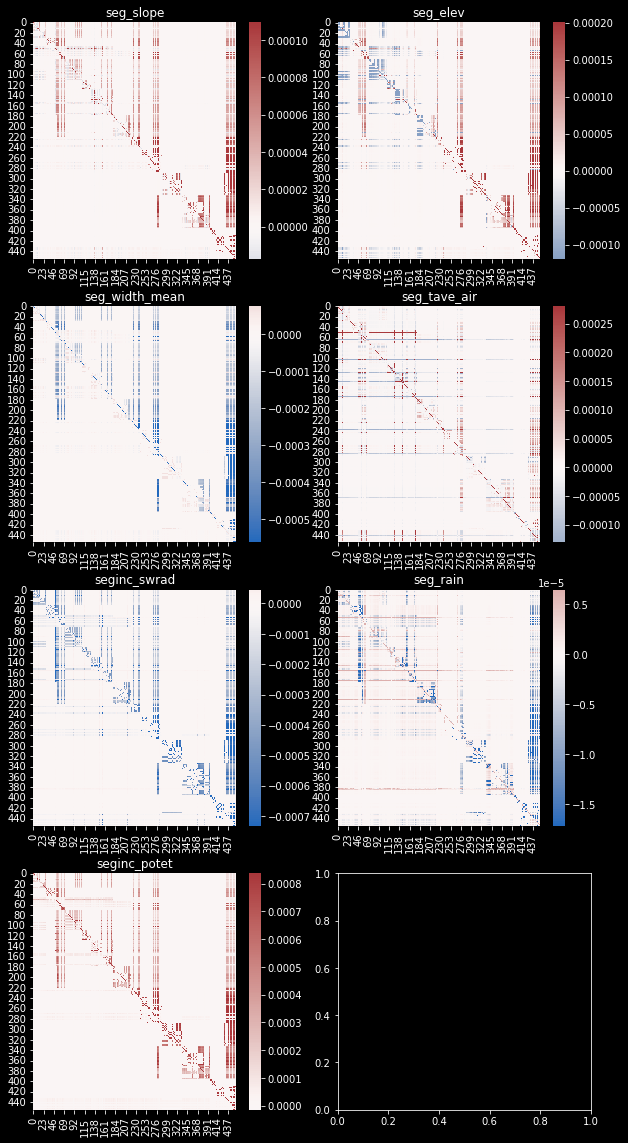

In [10]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))

for i in range(num_vars):
    IG = seg2seg_influence[:,:,i]
    low_lim = np.quantile(IG,.01)
    high_lim = np.quantile(IG,.99)
    sns.heatmap(IG, vmin=low_lim,vmax=high_lim, center=0,cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(x_vars[i])

plt.tight_layout
plt.show()


## Pretty hard to interpret, lets try an experiment where we noise everything but the target reach

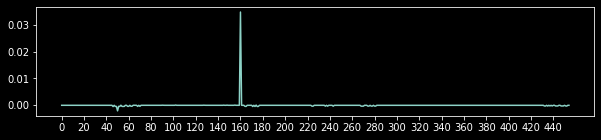

In [37]:
x_vars[4]
fig = plt.figure(figsize=(10,2))
#plt.ylim(-.001,0.001)
plt.xticks(np.arange(0, 455, 20))
plt.plot(seg2seg_influence[160,:,4])

seg_clusters = seg2seg_influence[160,:,4] < -0.0002

<AxesSubplot:>

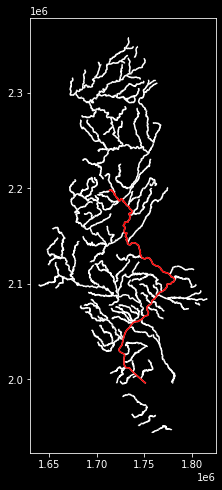

In [36]:
seg_clusters_sf = pd.DataFrame({'sg_d_nt':seg_ids, 'ig_vals':seg2seg_influence[160,:,4]}).merge(segs).set_geometry('geometry')
fig, ax = plt.subplots(figsize =(5,8))
seg_clusters_sf.plot(ax=ax)
seg_clusters_sf.loc[seg_clusters_sf.ig_vals < -0.0002].plot(ax=ax,color='red')

In [43]:
y_trn = river_dl['y_obs_trn']
non_zero = np.where(np.isfinite(y_trn),np.ones_like(y_trn),np.zeros_like(y_trn))
non_zero=non_zero.reshape(n_segs,river_dl['y_obs_trn'].shape[0]//n_segs,180,1)

In [51]:
sums = np.add.reduce(non_zero,axis=1)
sums = np.add.reduce(sums,axis=1)
sums = np.add.reduce(sums,axis=1)


(455,)

<AxesSubplot:>

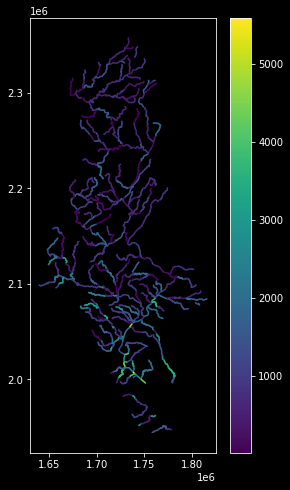

In [54]:
seg_sums_sf = pd.DataFrame({'sg_d_nt':seg_ids, 'sums':sums}).merge(segs).set_geometry('geometry')
fig, ax = plt.subplots(figsize =(5,8))
seg_sums_sf.plot(column='sums',ax=ax,legend=True)#seg_clusters_sf.loc[seg_clusters_sf.ig_vals < -0.0002].plot(ax=ax,color='red')

In [ ]:
np.sum,reduce

In [9]:
def noise_segs(seg_of_interest):
    with torch.no_grad():
        y_hat_original = model(x)[:,-pred_length:,:]
    x_hypothesis = torch.rand_like(x)
    x_hypothesis[seg_of_interest] = x[seg_of_interest]
    with torch.no_grad():
        y_hat_hypothesis = model(x_hypothesis)[:,-pred_length:,:]
    y_diff = y_hat_original[seg_of_interest, :].detach().cpu() - y_hat_hypothesis[seg_of_interest, :].detach().cpu()
    y_diff = np.mean(y_diff.numpy())
    return y_diff

In [23]:
num_rand=4
batches = river_dl['x_trn'].shape[0]//n_segs
rand_batch = np.random.choice(range(batches),num_rand,replace='False')
batches, rand_batch

(650, array([358, 213, 630, 411]))

In [24]:
diffs =[]
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_trn']).to(device).float()[start_ind:end_ind] 
    for j in range(n_segs):
        d = noise_segs(j)
        diffs.append(d)

diffs = np.asarray(diffs).reshape(num_rand,n_segs).mean(axis=0)
diffs = diffs*river_dl['y_std'][0]
diffs_sf = pd.DataFrame({'sg_d_nt':seg_ids, 'diffs':np.abs(diffs)}).merge(segs).set_geometry('geometry')
diffs.shape

(455,)

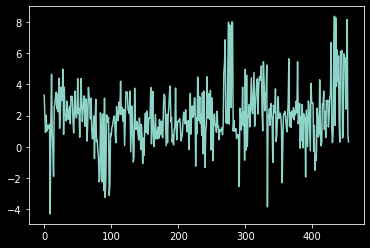

In [25]:
plt.plot(diffs)

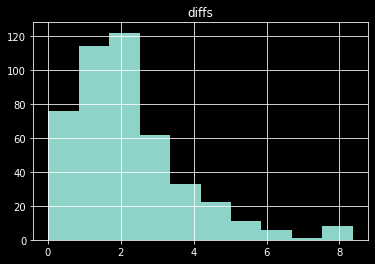

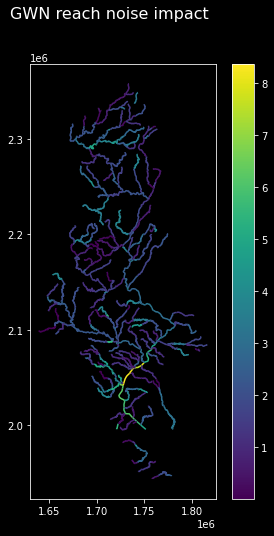

In [26]:
diffs_sf.hist('diffs')
fig, ax = plt.subplots(figsize = (6,8))
diffs_sf.plot(column='diffs', ax = ax, legend = True)
fig.suptitle(f"{mod} reach noise impact",fontsize=16)
plt.savefig(f'../figures/{mod}_30_reach_noise.png',bbox_inches='tight')

## Lets do a similar exercice, but use IGs to look at specific reaches of interest

1638-Contains Neversink; 1639 downstream

1560,1562-Contains Cannonsville; 1566 downstream 

1449-Contains Popocton, 1450 downstream

Random mainstem downstream 1780, 1817 

In [13]:
reach = np.where(seg_ids == 1566)[0][0]

In [15]:
batches = river_dl['x_tst'].shape[0]/n_segs
rand_batch = np.random.choice(range(batches),num_rand,replace='False')

igs = []
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
    IG_vals = integrated_gradients(x, model, grad_steps, baseline, spatial_focus=reach,temporal_focus=range(pred_length,seq_len))
    IG_vals[reach,:,:] = np.nan
    reduced = np.mean(np.abs(IG_vals),axis=1)
    igs.append(reduced)
igs = np.asarray(igs).mean(axis=0)

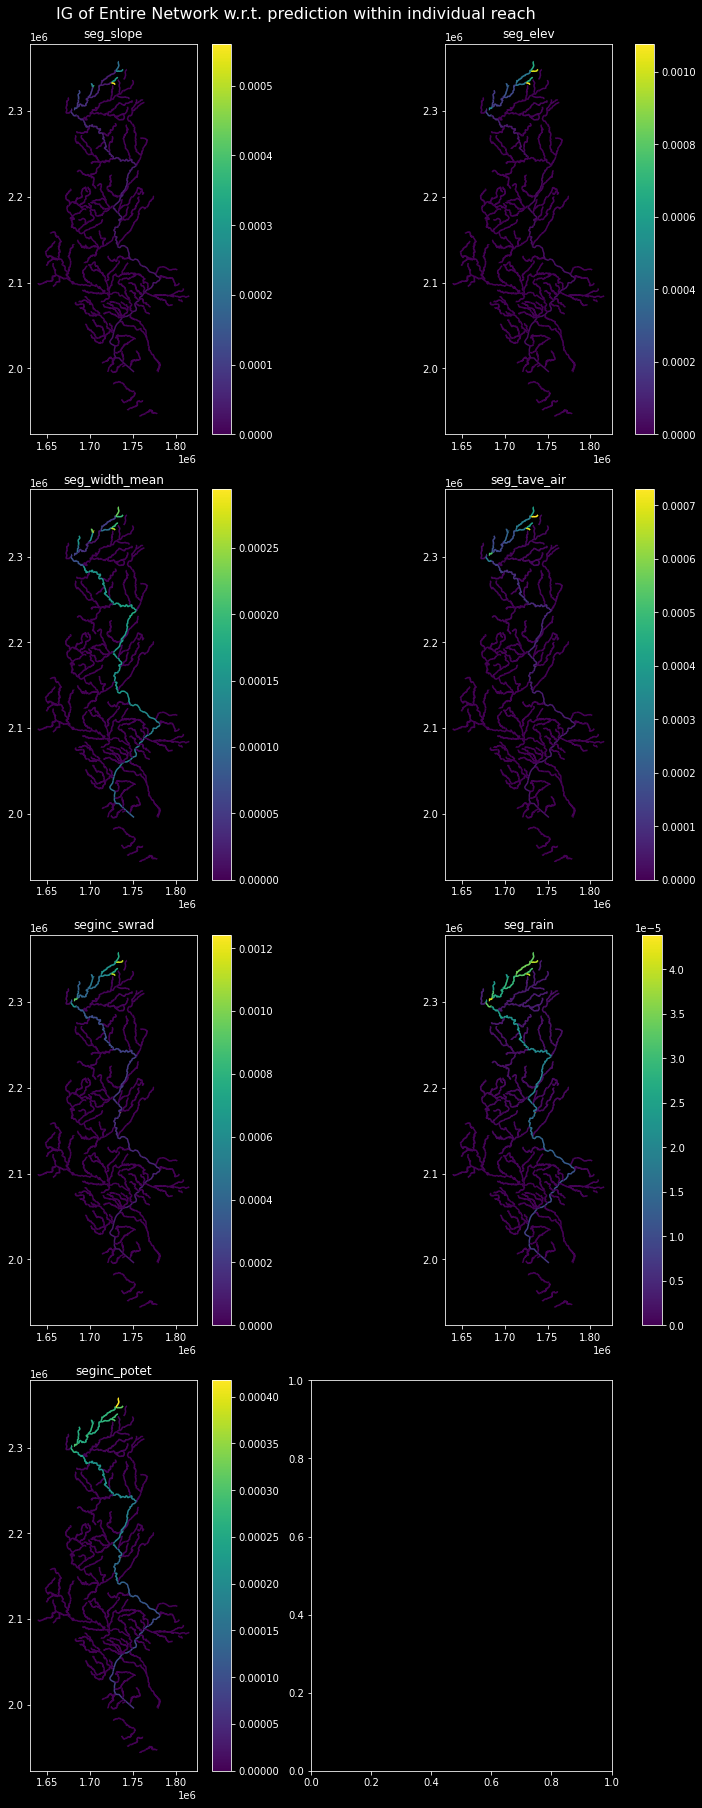

In [16]:
#igs_sf = pd.DataFrame({'sg_d_nt':ids[:len(diffs)], 'igs':reduced}).merge(segs).set_geometry('geometry')
igs_sf = pd.DataFrame(columns=river_dl['x_vars'],data=igs)
igs_sf['sg_d_nt']=seg_ids
igs_sf = igs_sf.merge(segs).set_geometry('geometry')
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(11.2,25),constrained_layout=True)
fig.suptitle('IG of Entire Network w.r.t. prediction within individual reach',fontsize=16)
for i in range(num_vars):
    igs_sf.plot(column=river_dl['x_vars'][i],ax = axes.reshape(-1)[i],legend=True)
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i]) 

## Lets do some time traveling

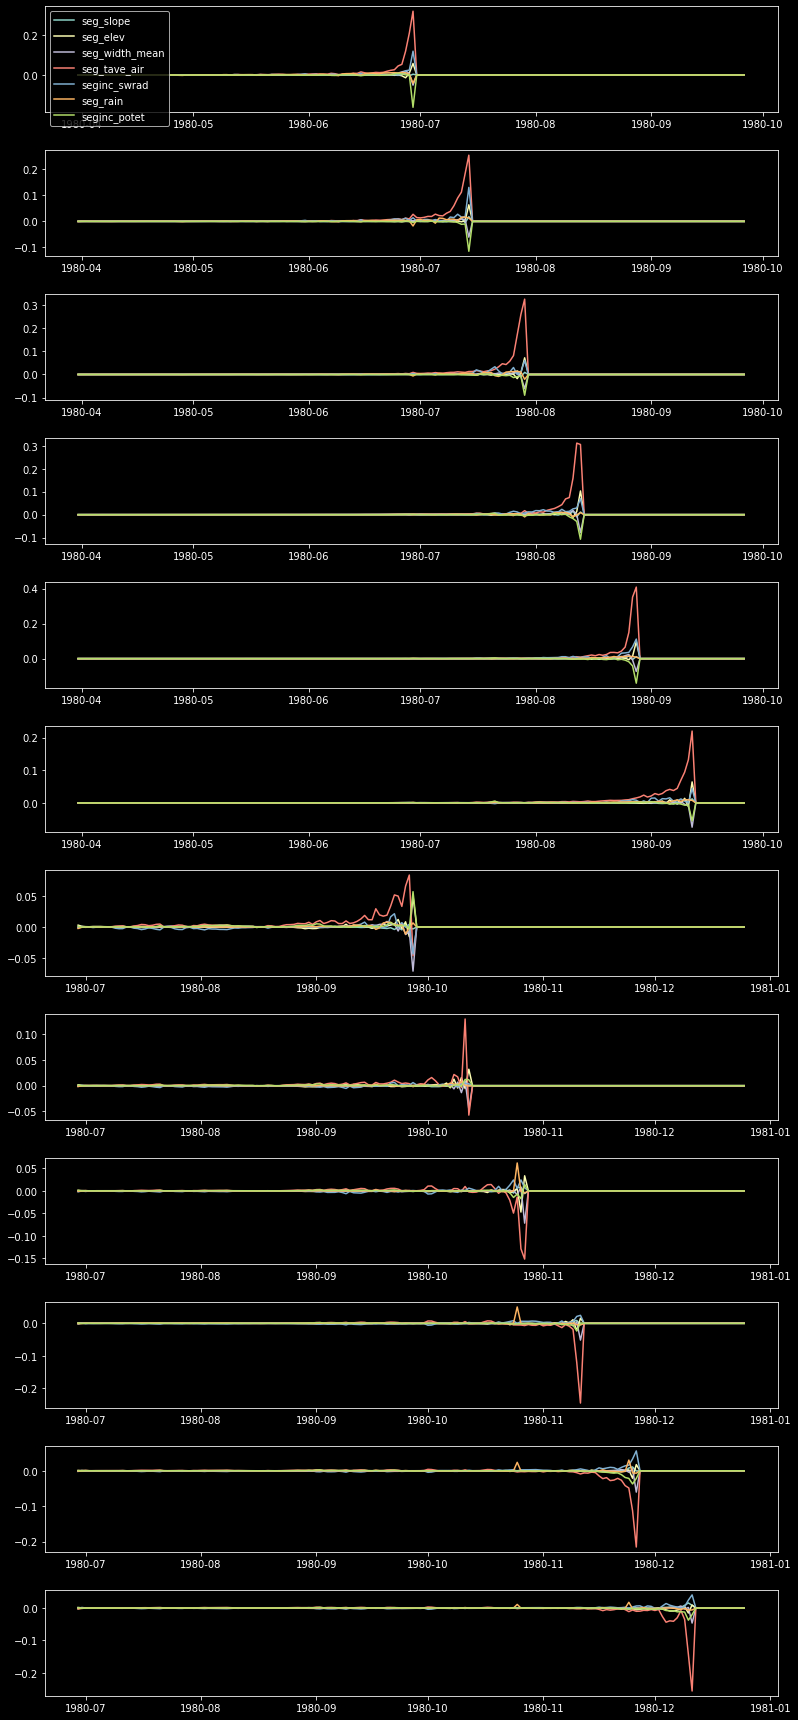

In [43]:
#df = pd.DataFrame(columns=['date','ig_val'])
time_steps = 24
step_interval=15
## Hard to make this applicable to both models because of differences in sequence length
if mod=='RGCN':
    steps_per_seq = seq_len//step_interval
    num_sequences = 1+time_steps//steps_per_seq
    igs = []
    dates=[]
    for i in range(1,num_sequences):
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
        dates_x = river_dl['times_tst'][start_ind:end_ind][0].flatten()
        obs = range(pred_length,seq_len,step_interval)
        for j in obs:
            attributions = integrated_gradients(x,model, n_steps=2, baseline_x=baseline, temporal_focus = j) # attributions for last day in the sequence
            igs.append(np.mean(attributions,axis=0))
            dates.append(dates_x)
        
if mod=='GWN':
    igs = []
    dates = []
    for i in range(1,time_steps):
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
        dates_x = river_dl['times_tst'][start_ind:end_ind][0].flatten()
        IG_vals = integrated_gradients(x, model, grad_steps, baseline, temporal_focus=-1)
        ig_temp_mean = np.mean(IG_vals, axis=0)
        igs.append(ig_temp_mean)
        dates.append(dates_x)

num_plots = len(dates)
fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,2*num_plots), tight_layout=True)
for j in range(num_plots):
    for i in range(num_vars):
        axes[j].plot(dates[j],igs[j][:, i], label = river_dl['x_vars'][i])
    if j == 0:
        axes[j].legend(loc = 'upper left')

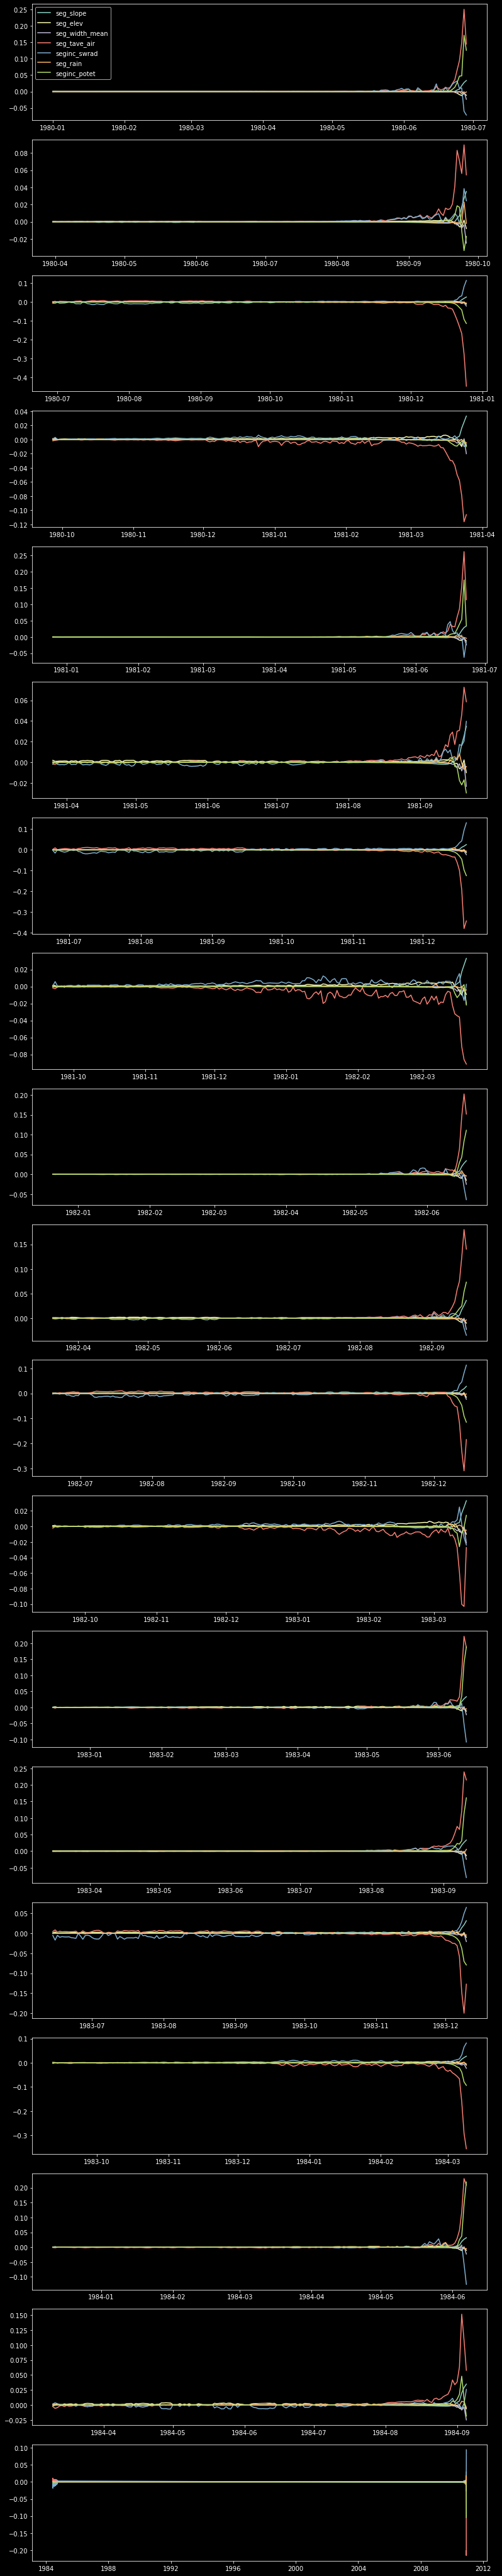

In [18]:
#igs=np.assarray(igs)


## Try to get high level idea of how it works seasonally

In [46]:
dates = river_dl['times_tst']
months = dates.astype('datetime64[M]').astype(int) % 12 + 1 #d.DatetimeIndex(river_dl['times_tst'])
mask= np.isin(months[:,-1,0],[1,2])
dates_filt = dates[mask]
dates.shape, mask.shape, dates_filt.shape


((106470, 60, 1), (106470,), (16835, 60, 1))

In [47]:
num_rand=10
grad_steps = 2
seasons = [[6,7,8],[9,10,11],[12,1,2],[3,4,5]]
igs_months=[]
for m in seasons:
    mask= np.isin(months[:,-1,0],m)
    batches = river_dl['x_tst'][mask].shape[0]//n_segs
    rand_batch = np.random.choice(range(batches-1),num_rand,replace='False')
    igs=[]
    for i in rand_batch:
        start_ind = n_segs*i
        end_ind = n_segs*i+n_segs
        x = torch.from_numpy(river_dl['x_tst'][mask]).to(device).float()[start_ind:end_ind]
        IG_vals = integrated_gradients(x, model, grad_steps, baseline,temporal_focus=-1)
        reduced = np.mean(IG_vals,axis=0) #reduce across segments
        igs.append(reduced)
    igs_mean = np.asarray(igs).mean(axis=0) #reduce across batches
    igs_std = np.asarray(igs).std(axis=0)
    igs_months.append(np.array([igs_mean,igs_std]))


In [48]:
igs_months[0].shape

(2, 60, 7)

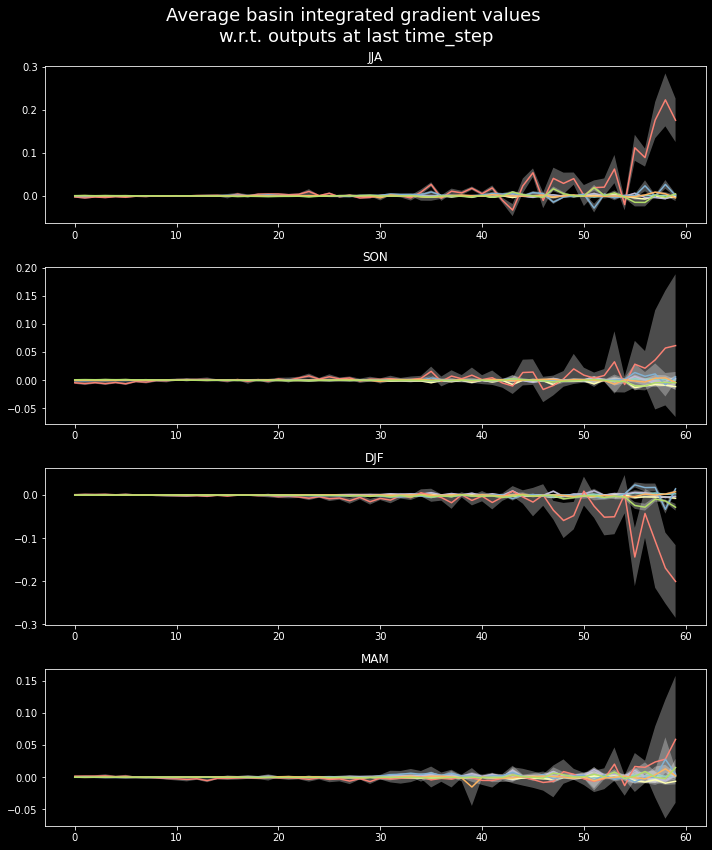

In [49]:
#igs = np.asarray(igs).mean(axis=0)
fig, axes = plt.subplots(nrows=len(igs_months),figsize = (10,12),tight_layout=True)
s=0
e=60
#labs = ['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec']
labs = ['JJA','SON','DJF','MAM']
for i in range(len(igs_months)):
    mean = igs_months[i][0]
    sd = igs_months[i][1]
    [axes[i].plot(range(s,e),mean[s:e,j]) for j in range(num_vars)]
    [axes[i].fill_between(x=range(s,e),y1=mean[s:e,j]+sd[s:e,j],y2=mean[s:e,j]-sd[s:e,j], facecolor='white',alpha=.3) for j in range(num_vars)]
    axes[i].set_title(labs[i])
    #axes[i].set_ylim(0,.4)
#for i in range(num_vars):
#    plt.plot(igs[:, i],label=x_vars[i])
fig.suptitle('Average basin integrated gradient values \nw.r.t. outputs at last time_step',
          fontsize = 18);

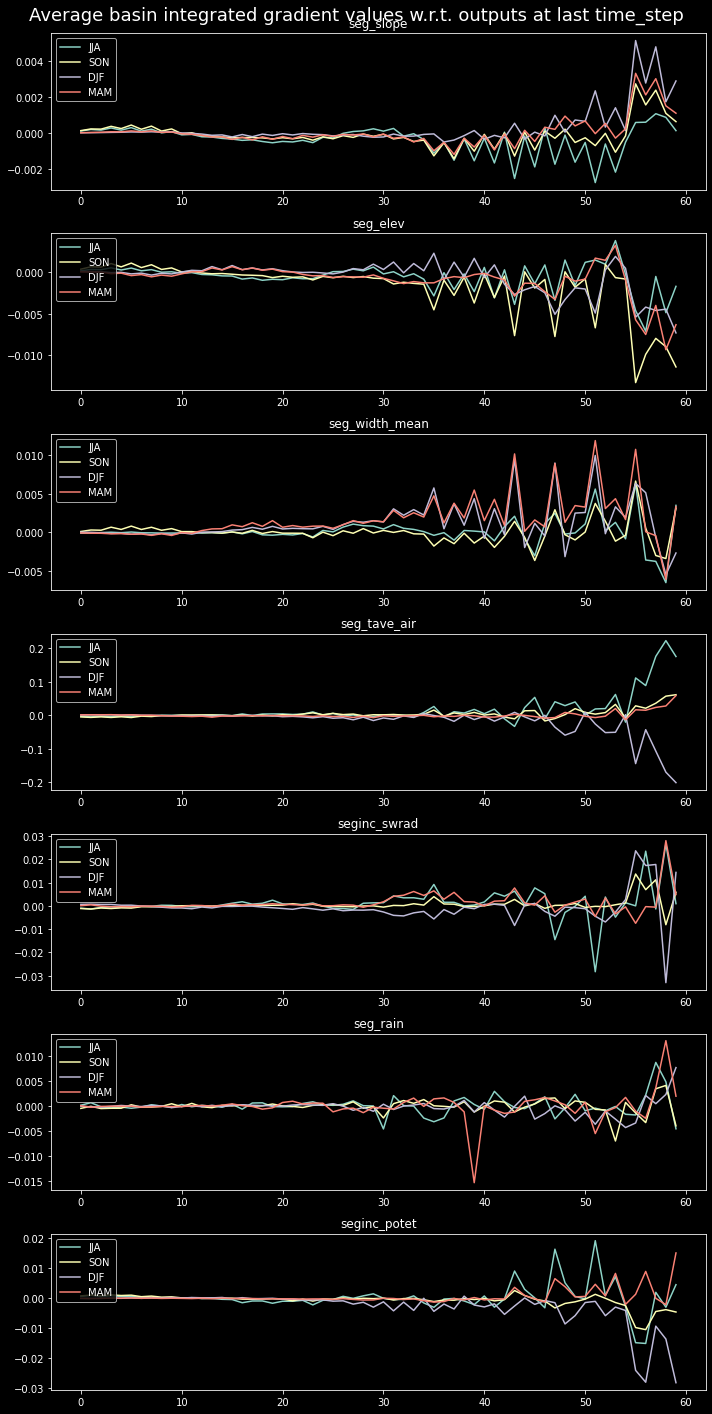

In [50]:
# #igs = np.asarray(igs).mean(axis=0)
fig, axes = plt.subplots(nrows=len(x_vars),figsize = (10,20),tight_layout=True)
check = np.asarray(igs_months)
labs = ['JJA','SON','DJF','MAM']
for i in range(len(x_vars)):
    #mean = check[i][0]
    #sd = check[i][1]
    [axes[i].plot(range(s,e),check[j,0,s:e,i], label = labs[j]) for j in range(4)]
    #[axes[i].fill_between(x=range(s,e),y1=check[j,0,s:e,i]+check[j,1,s:e,i],
    #                      y2=check[j,0,s:e,i]-check[j,1,s:e,i],
    #                      facecolor='white',alpha=.3) for j in range(4)]
    axes[i].set_title(x_vars[i])
    axes[i].legend(loc='upper left')

#for i in range(num_vars):
#    plt.plot(igs[:, i],label=x_vars[i])
fig.suptitle('Average basin integrated gradient values w.r.t. outputs at last time_step',
          fontsize = 18);

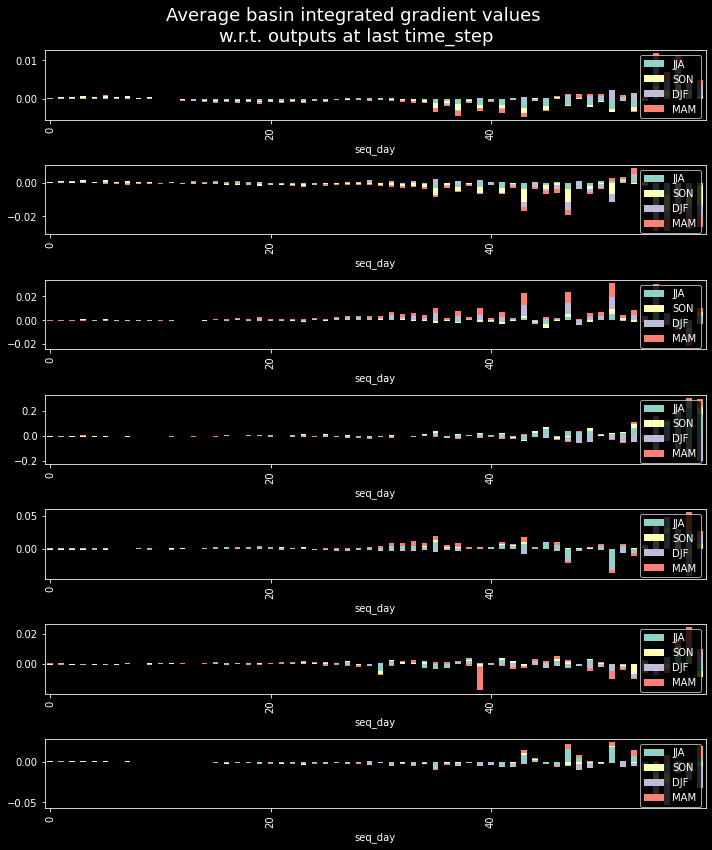

In [51]:
fig, axes = plt.subplots(nrows=len(x_vars),figsize = (10,12),tight_layout=True)

for i in range(len(x_vars)):
    df = pd.DataFrame(check[:,0,s:e,i].transpose(),columns = labs)
    df['seq_day']=range(s,e)
    df.plot(x='seq_day',kind='bar',stacked=True, ax=axes[i], xticks= range(s,e,20))

#for i in range(num_vars):
#    plt.plot(igs[:, i],label=x_vars[i])
fig.suptitle('Average basin integrated gradient values \nw.r.t. outputs at last time_step',
          fontsize = 18);

In [12]:
np.isin?

Signature: np.isin(element, test_elements, assume_unique=False, invert=False)
Docstring:
Calculates `element in test_elements`, broadcasting over `element` only.
Returns a boolean array of the same shape as `element` that is True
where an element of `element` is in `test_elements` and False otherwise.

Parameters
----------
element : array_like
    Input array.
test_elements : array_like
    The values against which to test each value of `element`.
    This argument is flattened if it is an array or array_like.
    See notes for behavior with non-array-like parameters.
assume_unique : bool, optional
    If True, the input arrays are both assumed to be unique, which
    can speed up the calculation.  Default is False.
invert : bool, optional
    If True, the values in the returned array are inverted, as if
    calculating `element not in test_elements`. Default is False.
    ``np.isin(a, b, invert=True)`` is equivalent to (but faster
    than) ``np.invert(np.isin(a, b))``.

Returns
----

In [123]:
df = pd.DataFrame(check[:,0,:-15,i].transpose(),columns=labs)